# トレンドの構造

時系列分析では、長期的な変動傾向を表すトレンドを推定することがある。ここでは、トレンドの扱い方を説明する。

## 確定的トレンド

トレンドには確定的トレンドと確率的トレンドの二種類がある。

確定的トレンドは、単位時間ごとの変化が常に一定であることで、次のように書ける。
$$
y_{t+1} - y_t = \delta
$$
初期値$y_0$がわかれば、次のようにある時点での観測値が分かる。
$$
y_t = y_0 + \sum_{i=1}^t\delta = y_0 + t\delta
$$

よって、確定的トレンドは、経過日数を説明変数にした単回帰モデルによって推定することができる。
$$
y_t = y_0 + t\delta + v_t \qquad v_t \sim Normal(0, \sigma_v^2)
$$

## 確率的トレンド

確率的トレンドとは、単位時間ごとの変化が確率的に変化することで、次のように書ける。
$$
\mu_{t+1}-\mu_t = w_t \qquad w_t \sim Normal(0, \sigma_w^2)
$$
これはまさにランダムウォークである。

次のように表されるローカルレベルモデルは確率的トレンドに観測誤差が加わったものであると考えられる。
$$
\mu_t = \mu_{t-1} + w_t, \qquad w_t \sim Normal(0, \sigma_w^2) \\
y_t = \mu_t + v_t \qquad v_t \sim Normal(0, \sigma_v^2)
$$

ローカルレベルモデルでは1時点前の状態との差分が正規ホワイトノイズに従うとしているため、時点によってトレンドの値が大きく変わってしまうことがある。そのため、次のように状態方程式を定式化した平坦化トレンドモデルを考える。

### 平坦化トレンドモデル

平坦化トレンドモデルは次のように状態方程式を書く。
$$
(\mu_t - \mu_{t-1}) - (\mu_{t-1} - \mu_{t-2}) = \zeta_t, \qquad \zeta_t \sim Normal(0, \sigma_{\zeta}^2)
$$
これは、差分の差分が正規ホワイトノイズに従うと仮定したモデルである。これを式変形すると次のようになる。
$$
(\mu_t - \mu_{t-1}) = (\mu_{t-1} - \mu_{t-2}) + \zeta_t
$$
これは、1時点での差分が、その前の時点の差分に誤差を加えたものになるということで、増減量が前回の増減量に似た値になるということを表現できている。

さらに変形すると次のようになる。
$$
\mu_t \sim Normal(2\mu_{t-1} - \mu_{t-2}, \sigma_{\zeta}^2)
$$

平坦化トレンドモデルは次のようにトレンド成分を外に出すことで、解釈が容易なモデルにすることができる。
$$
\delta_t = \delta_{t-1} + \zeta_t \qquad \zeta_t \sim Normal(0, \sigma_{\zeta}^2) \\
\mu_t = \mu_{t-1} + \delta_{t-1}
$$
このようにトレンドを外に出すことで解釈が容易になるだけでなく、トレンドの次数を増やすことができる。N階差分を含めた状態空間モデルはN次トレンドモデルと呼ばれる。

### ローカル線形トレンドモデル

上の式で、$\mu_t, \delta_t$はそれぞれ、水準成分、ドリフト成分と呼ぶ。平坦化トレンドモデルではドリフト成分がランダムウォークすることを仮定しているが、水準成分に関しては過程誤差が含まれていない。水準誤差にも過程誤差を含んだモデルをローカル線形トレンドモデルという。
$$
\delta_t = \delta_{t-1} + \zeta_t \qquad \zeta_t \sim Normal(0, \sigma_{\zeta}^2) \\
\mu_t = \mu_{t-1} + \delta_{t-1} + w_t \qquad w_t \sim Normal(0, \sigma_w^2)
$$

平坦化トレンドモデルはローカル線形トレンドモデルの特殊系と考えられる。

ローカルレベルモデル、平坦化トレンドモデル、ローカル線形トレンドモデルの3つについてpystanで実装し、違いを確認する。

## pystanでの実装

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

### データの説明

次の図に見るように売り上げデータは、徐々に増え、徐々に減っていくトレンドをもつ

In [5]:
sales = pd.read_csv('../data/4-5-sales.csv')
sales['date'] = [datetime.strptime(i, "%Y-%m-%d") for i in sales["date"]]

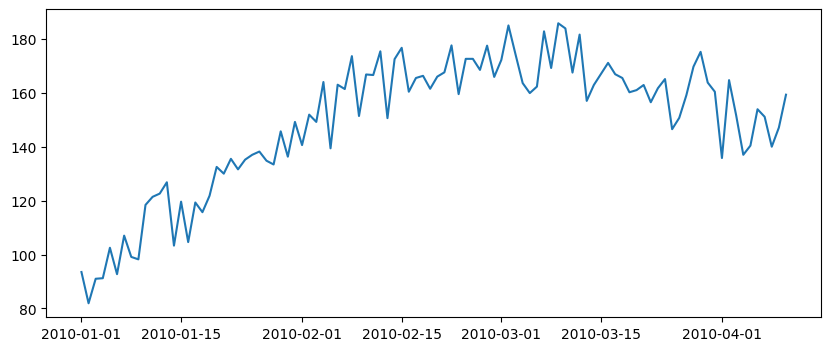

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
axes.plot(sales['date'], sales['sales'])
plt.show()

### 各モデルでのMCMCの実行

In [8]:
y = sales['sales'].values
T = len(y)

In [9]:
stan_data = {
    'T': T,
    'y': y
}

In [11]:
with open('../stan/4-2-local-level-model.stan') as f:
    local = f.read()
    
with open('../stan/4-5-1-smooth-trend.stan') as f:
    smooth = f.read()

with open('../stan/4-5-2-local-linear-trend.stan') as f:
    linear = f.read()

In [ ]:
sm_local = stan.build(local, data=stan_data, random_seed=123)

In [ ]:
sm_smooth = stan.build(smooth, data=stan_data, random_seed=123)

In [ ]:
sm_linear = stan.build(linear, data=stan_data, random_seed=123)

In [13]:
fit_local = sm_local.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (1/30000)
Sampling:   0% (2/30000)
Sampling:   0% (3/30000)
Sampling:   3% (902/30000)
Sampling:  36% (10901/30000)
Sampling:  70% (20900/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 8.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_dg0mvag0/model_brna6zjd.stan', line 14, column 8 to column 37)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler 

In [14]:
fit_smooth = sm_smooth.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (1/30000)
Sampling:   0% (2/30000)
Sampling:   0% (3/30000)
Sampling:   0% (102/30000)
Sampling:   1% (201/30000)
Sampling:   1% (300/30000)
Sampling:   1% (400/30000)
Sampling:   2% (500/30000)
Sampling:   2% (600/30000)
Sampling:   2% (700/30000)
Sampling:   3% (800/30000)
Sampling:   3% (900/30000)
Sampling:   3% (1000/30000)
Sampling:   4% (1100/30000)
Sampling:   4% (1200/30000)
Sampling:   4% (1300/30000)
Sampling:   5% (1400/30000)
Sampling:   5% (1500/30000)
Sampling:   5% (1600/30000)
Sampling:   6% (1700/30000)
Sampling:   6% (1800/30000)
Sampling:   6% (1900/30000)
Sampling:   7% (2000/30000)
Sampling:   7% (2100/30000)
Sampling:   7% (2200/30000)
Sampling:   8% (2300/30000)
Sampling:   8% (2400/30000)
Sampling:   8% (2500/30000)
Sampling:   9% (2601/30000)
Sampling:   9% (2701/30000)
Sampling:   9% (2801/30000)
Sampling:  10% (2900/30000)
Sampling:  10% (3001/30000)
Sampling:  10% (3101/30000)
Sampling:  11% (3202/30000)
Sampling:  11% (3301/30

In [15]:
fit_linear = sm_linear.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (1/30000)
Sampling:   0% (2/30000)
Sampling:   0% (3/30000)
Sampling:   0% (102/30000)
Sampling:   1% (301/30000)
Sampling:   1% (400/30000)
Sampling:   2% (500/30000)
Sampling:   2% (600/30000)
Sampling:   2% (700/30000)
Sampling:   3% (900/30000)
Sampling:   3% (1000/30000)
Sampling:   4% (1100/30000)
Sampling:   4% (1300/30000)
Sampling:   5% (1400/30000)
Sampling:   5% (1500/30000)
Sampling:   6% (1700/30000)
Sampling:   6% (1900/30000)
Sampling:   7% (2000/30000)
Sampling:  37% (11200/30000)
Sampling:  68% (20500/30000)
Sampling:  74% (22200/30000)
Sampling:  76% (22700/30000)
Sampling:  76% (22900/30000)
Sampling:  77% (23200/30000)
Sampling:  79% (23700/30000)
Sampling:  80% (24000/30000)
Sampling:  80% (24100/30000)
Sampling:  81% (24300/30000)
Sampling:  82% (24500/30000)
Sampling:  84% (25300/30000)
Sampling:  87% (26000/30000)
Sampling:  88% (26300/30000)
Sampling:  89% (26700/30000)
Sampling:  90% (27100/30000)
Sampling:  91% (27300/30000)
Samp

### 各モデルの状態の推移を図示

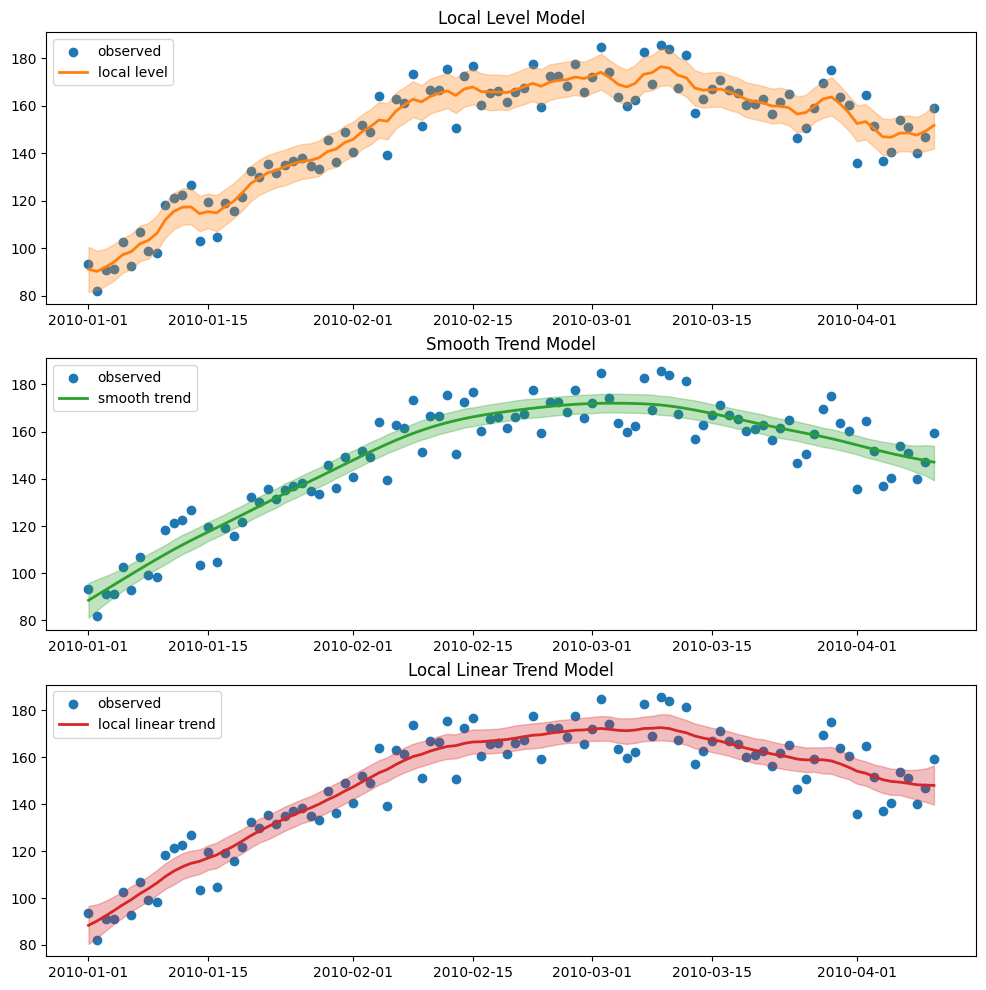

In [19]:
cmap = plt.get_cmap("tab10")

local_mean = az.summary(fit_local, var_names=["mu"])["mean"].values
smooth_mean = az.summary(fit_smooth, var_names=["mu"])["mean"].values
linear_mean = az.summary(fit_linear, var_names=["mu"])["mean"].values

local_hdis = az.hdi(fit_local, var_names=["mu"])["mu"].values
smooth_hdis = az.hdi(fit_smooth, var_names=["mu"])["mu"].values
linear_hdis = az.hdi(fit_linear, var_names=["mu"])["mu"].values

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].scatter(sales['date'], sales['sales'], color=cmap(0), label="observed")
axes[1].scatter(sales['date'], sales['sales'], color=cmap(0), label="observed")
axes[2].scatter(sales['date'], sales['sales'], color=cmap(0), label="observed")

axes[0].plot(sales['date'], local_mean, color=cmap(1), lw=2, label="local level")
axes[1].plot(sales['date'], smooth_mean, color=cmap(2),lw=2, label="smooth trend")
axes[2].plot(sales['date'], linear_mean, color=cmap(3),lw=2, label="local linear trend")

axes[0].fill_between(sales['date'], local_hdis[:, 0], local_hdis[:, 1], color=cmap(1), alpha=0.3)
axes[1].fill_between(sales['date'], smooth_hdis[:, 0], smooth_hdis[:, 1], color=cmap(2), alpha=0.3)
axes[2].fill_between(sales['date'], linear_hdis[:, 0], linear_hdis[:, 1], color=cmap(3), alpha=0.3)

axes[0].set_title("Local Level Model")
axes[1].set_title("Smooth Trend Model")
axes[2].set_title("Local Linear Trend Model")

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")
axes[2].legend(loc="upper left")

plt.show()

ローカルレベルモデルはデータに引きずられて状態がぐにゃぐにゃしているのに対し、平坦化トレンドモデルはかなり平坦な状態の推移を持つ。

ローカル線形モデルではドリフト成分の図示もできる。

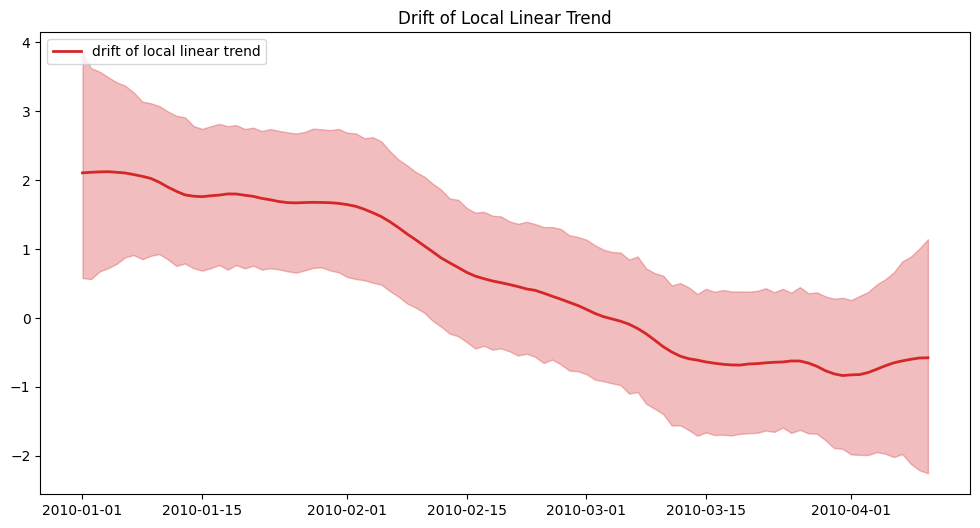

In [22]:
cmap = plt.get_cmap("tab10")

linear_mean = az.summary(fit_linear, var_names=["delta"])["mean"].values
linear_hdis = az.hdi(fit_linear, var_names=["delta"])["delta"].values

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(sales['date'], linear_mean, color=cmap(3),lw=2, label="drift of local linear trend")
axes.fill_between(sales['date'], linear_hdis[:, 0], linear_hdis[:, 1], color=cmap(3), alpha=0.3)
axes.set_title("Drift of Local Linear Trend")
axes.legend(loc="upper left")
plt.show()

最初のうちはドリフト成分が正の値を取り、毎日2万円ずつ増加しているが、徐々に増加量が減り、最後には売上が1万円減少する傾向が見て取れる。